In [3]:
import skimage.io as io

# Show the figures / plots inside the notebook
%matplotlib inline
from skimage.color import rgb2gray,rgb2hsv, rgba2rgb
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise
import numpy as np
from commonfunctions import *
from skimage import io, color, morphology
from skimage.measure import label, regionprops
from skimage.draw import polygon
from skimage import transform
from skimage.morphology import binary_closing
from scipy import ndimage
from skimage.morphology import remove_small_objects


from skimage.exposure import histogram
from matplotlib.pyplot import bar

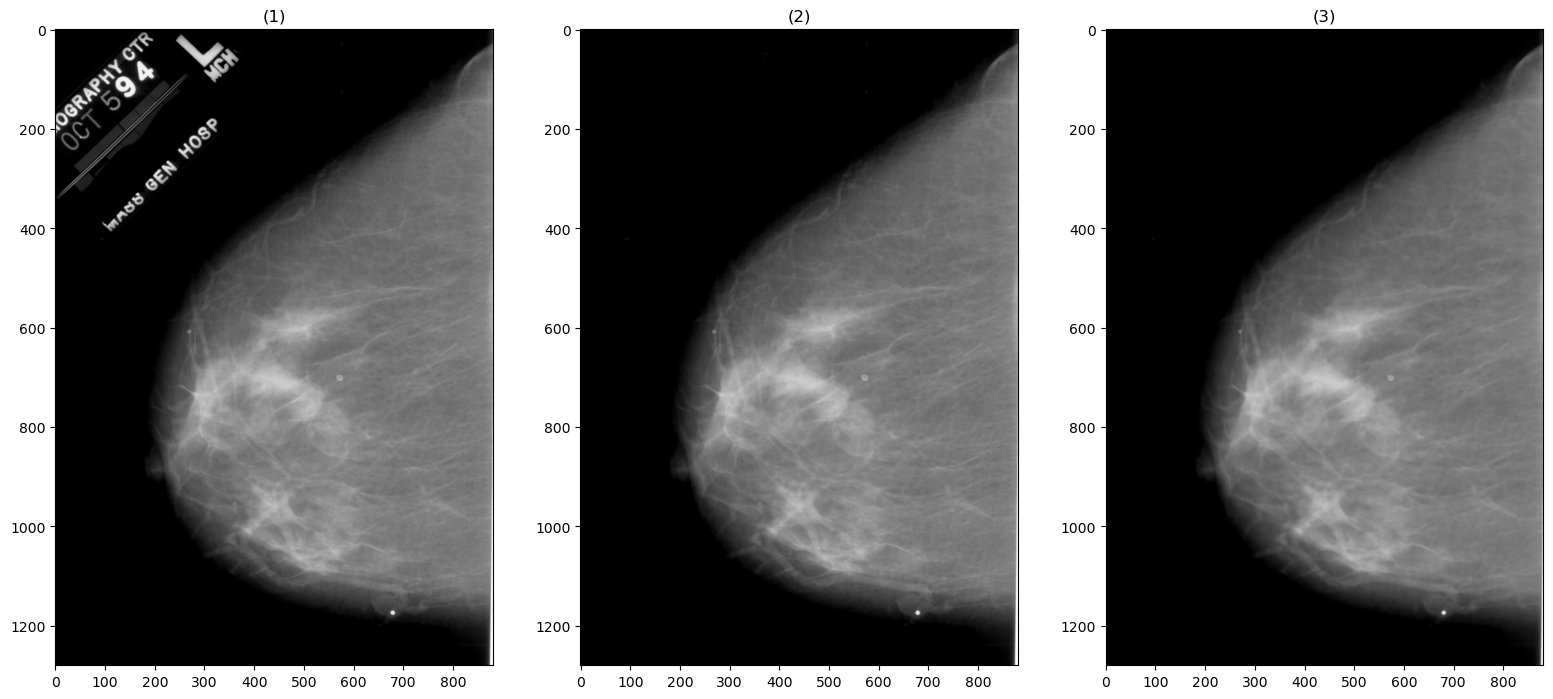

In [3]:
#image = io.imread("D:\image processing\Project\Breast-Cancer-Detection-IP\images\WhatsApp Image 2025-11-06 at 17.46.17_ea76d16f.jpg")
image = io.imread("images\WhatsApp Image 2025-11-06 at 17.46.17_ea76d16f.jpg")

img_gray = color.rgb2gray(image)
binary_img = img_gray > 0.3

top_crop = 410   # Height of label area
left_crop = 370  # Width of label area

# Create cleaned image by replacing top-left with background
cleaned_image = img_gray.copy()
cleaned_image[:top_crop, :left_crop] = 0  # Fill with black

filtered_image = ndimage.median_filter(cleaned_image, size=5)

show_images([image,cleaned_image,filtered_image])

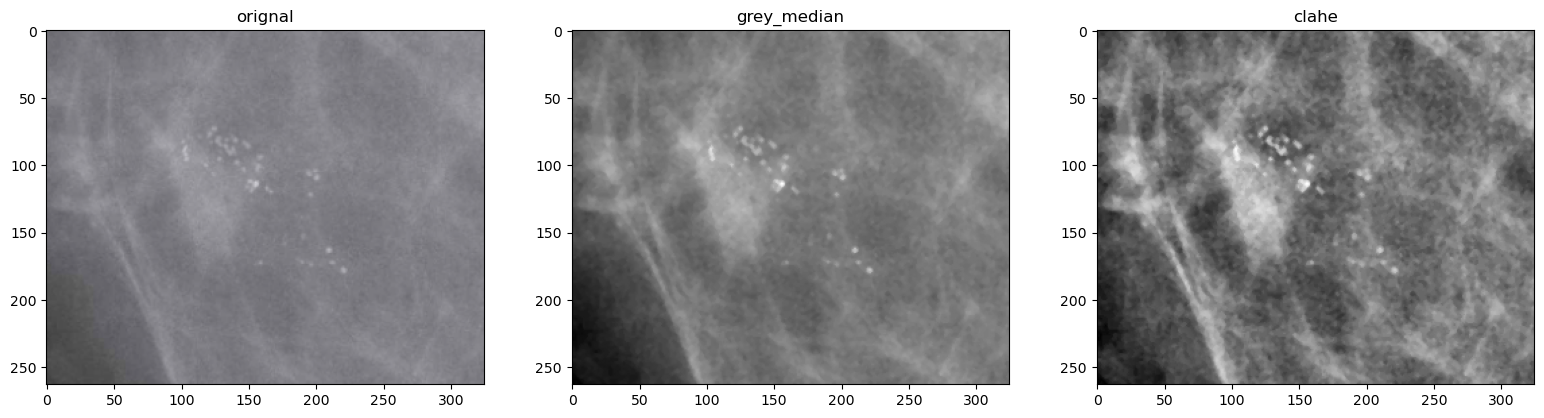

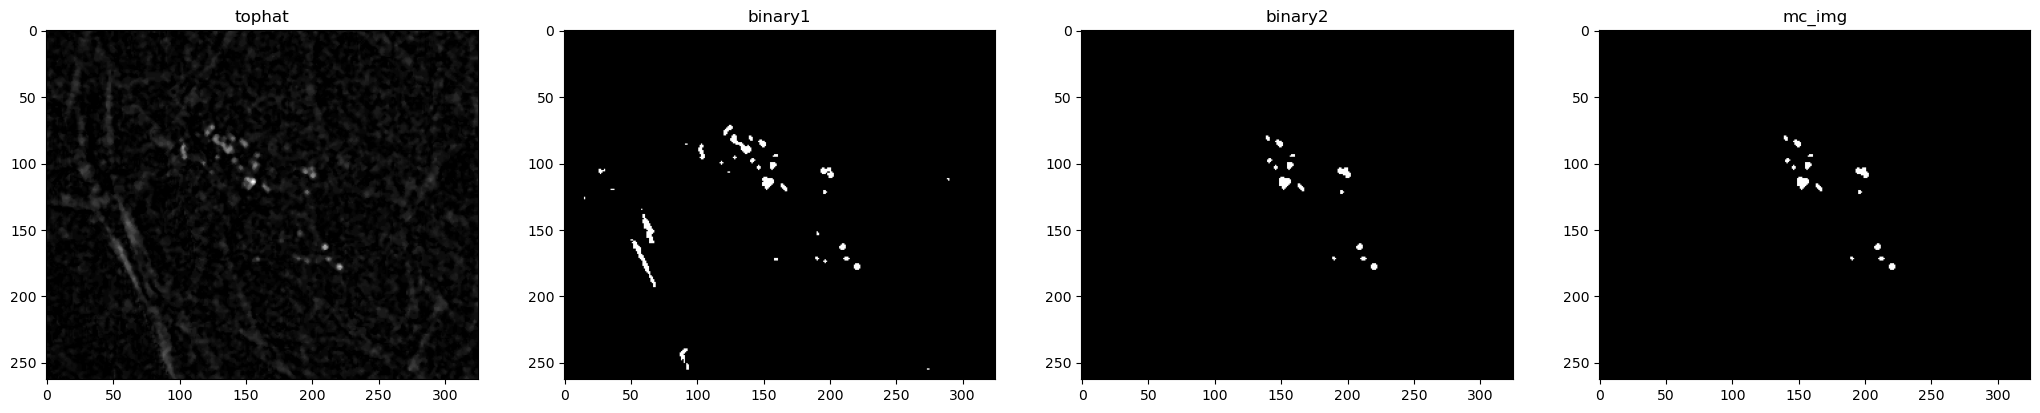

In [11]:

original = io.imread("images\image1.png")
#original = io.imread("images\image2.png")
img = rgba2rgb(original)
img = rgb2gray(img)

# Convert to uint8 (0-255) for OpenCV
img = (img * 255).astype(np.uint8)

# Apply median blur
img = cv2.medianBlur(img, 3)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(img)


# Structuring element (tune size depending on MC size)
#~10–20 pixels 
#5x5 Background is not removed properly → noisy image
#30x30 Some micro-calcifications may get removed
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12, 12))

#openning erosion -> dilation removes bright structures smaller than the kernel
eroded = cv2.erode(img, kernel, iterations=1)

opened = cv2.dilate(eroded, kernel, iterations=1)

#tophat original - opened (gets the small  bright structures)
tophat = cv2.subtract(img, opened)



# Normalize to 0-255
tophat_norm = cv2.normalize(tophat, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)



# Compute histogram
hist = cv2.calcHist([tophat_norm], [0], None, [256], [0,256])

total_pixels = tophat_norm.size
cumsum = np.cumsum(hist)
#pixel intensity where 99% of pixels are below it
threshold_idx = np.searchsorted(cumsum, total_pixels*0.99)
_, binary2 = cv2.threshold(tophat_norm, threshold_idx, 255, cv2.THRESH_BINARY)

kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
binary_closed = cv2.morphologyEx(binary2, cv2.MORPH_CLOSE, kernel_close)



contours, _ = cv2.findContours(binary_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mc_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if 2 < area < 50:  # MCs are tiny
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        circularity = 4*np.pi*(area/(perimeter**2))
        if 0.5 < circularity < 1.2:
            mc_contours.append(cnt)

mc_img = np.zeros_like(binary2)
cv2.drawContours(mc_img, mc_contours, -1, 255, -1)

mc_img_closed = np.zeros_like(binary_closed)
cv2.drawContours(mc_img_closed, mc_contours, -1, 255, -1)





show_images([original, img, clahe_img],["orignal", "grey_median", "clahe"])
show_images([tophat, binary2, mc_img, mc_img_closed],["tophat", "binary1", "binary2", "mc_img", "binary_closed"])


In [2]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


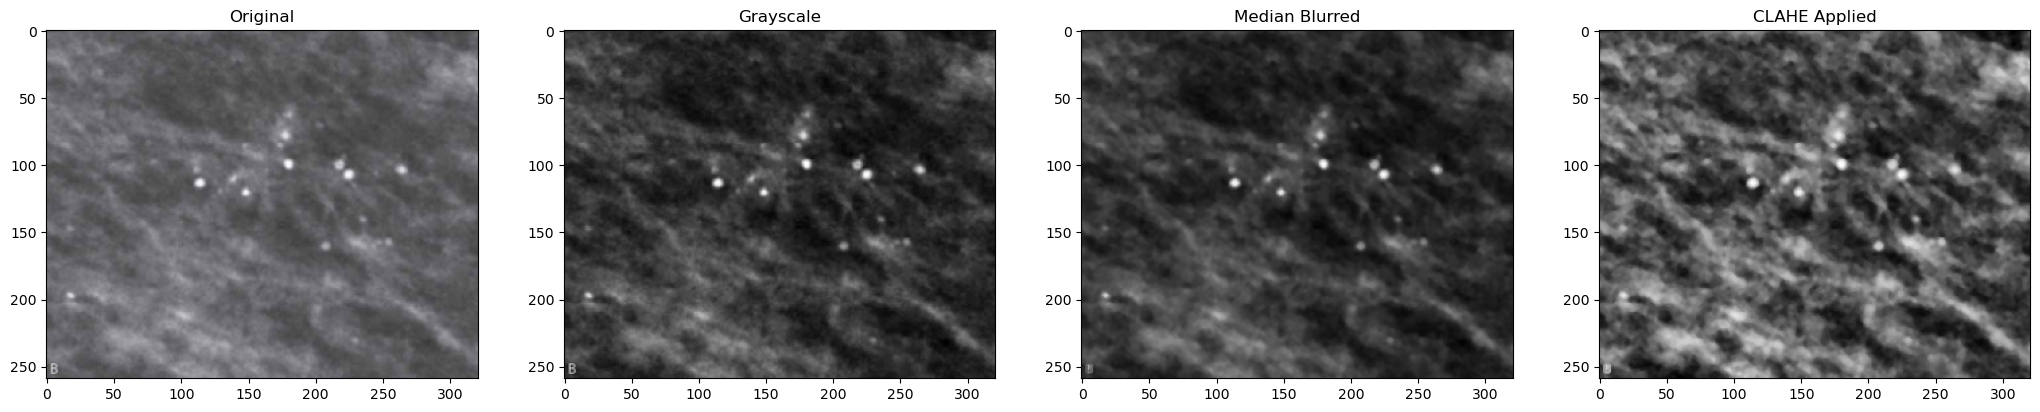

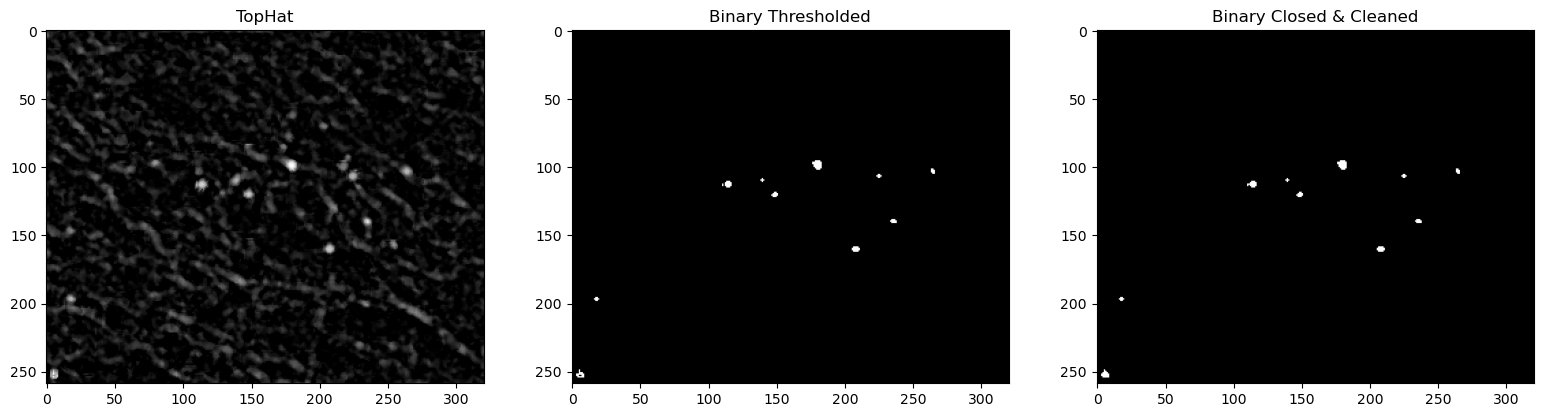

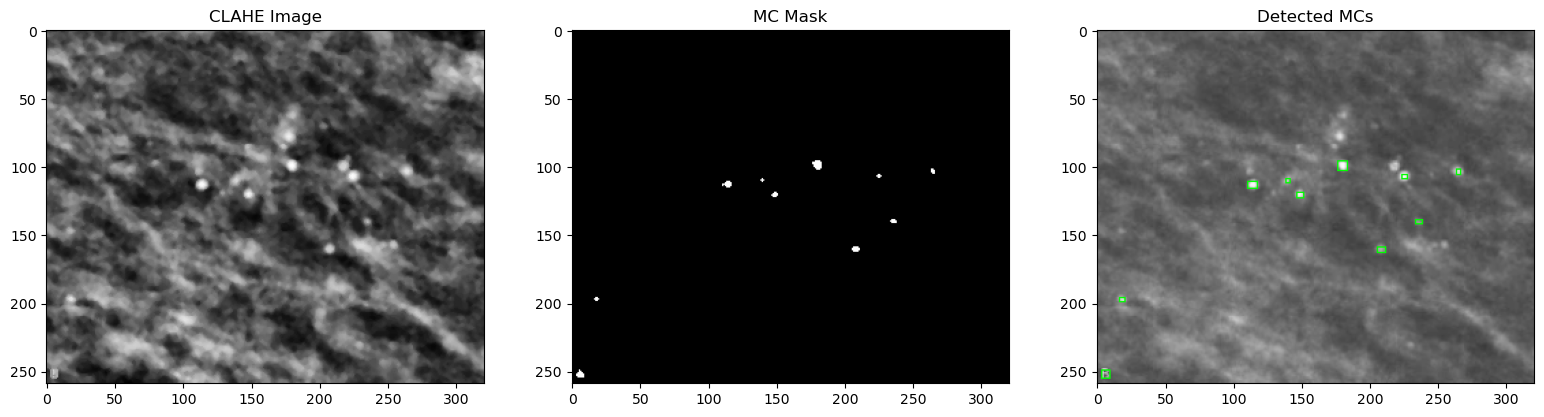

In [10]:

#original = io.imread("images\image1.png")
original = io.imread("images\image2.png")
img = rgba2rgb(original)
img = rgb2gray(img)
img = (img * 255).astype(np.uint8)   # uint8 for OpenCV

# --- 1) Denoise (adaptive) --------------------------------------------------
# estimate image noise by std; use small median for low noise, bigger for noisy images
noise_sigma = img.std()
if noise_sigma < 10:
    med_k = 3
elif noise_sigma < 30:
    med_k = 3
else:
    med_k = 5
img_med = cv2.medianBlur(img, med_k)


#(use clipLimit proportional to noise, safe bounds)
#if noise = 0 clip=1.5 if noise=50 clip=3.0 if between clip between 1.5-3.0
clip = float(np.interp(noise_sigma, [0, 50], [1.5, 3.0]))
clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
img_clahe = clahe.apply(img_med)

show_images([original, img, img_med, img_clahe],["Original", "Grayscale", "Median Blurred", "CLAHE Applied"])


# --- 2) Structuring element selection (adaptive) -----------------------------
# MCs are small bright spots: kernel should be slightly larger than MC scale.
# Infer kernel from image size: smaller images -> smaller kernel; larger -> larger kernel.
H, W = img.shape
diag = np.sqrt(H*H + W*W)
# base kernel ~ diag/50, clamped to sensible range
base = int(np.clip(diag / 50, 6, 24))
# make kernel odd/even as we like (elliptic kernel can be even); use balanced square
kernel_size = (base, base)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)


eroded = cv2.erode(img_clahe, kernel, iterations=1)
opened = cv2.dilate(eroded, kernel, iterations=1)
tophat = cv2.subtract(img_clahe, opened)

tophat_norm = cv2.normalize(tophat, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


# --- 3) Adaptive Thresholding -----------------------------------------------
#pixel intensity where 99% of pixels are below it

threshold_val = np.percentile(tophat_norm, 99.8)   # try 99.0, 99.5, 99.8
_, binary2 = cv2.threshold(tophat_norm, int(threshold_val), 255, cv2.THRESH_BINARY)




# --- 5) Morphological cleanup (closing + remove small objects) --------------
# closing to link small clusters, then remove tiny specks (area based on image size).
close_k = int(np.clip(base/3, 3, 9))
if close_k % 2 == 0: close_k += 1
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_k, close_k))
binary_closed = cv2.morphologyEx(binary2, cv2.MORPH_CLOSE, kernel_close, iterations=1)


# remove extremely small objects (too small to be MCs) -- scale by total pixels
min_area_px = max(2, int(0.00002 * H * W))   # default: 0.002% of image area
# convert to boolean for skimage removal then back
binary_bool = (binary_closed > 0)
binary_bool = remove_small_objects(binary_bool, min_size=min_area_px)
binary_closed = (binary_bool.astype(np.uint8) * 255)


show_images([tophat, binary2, binary_closed],["TopHat", "Binary Thresholded", "Binary Closed & Cleaned"])


# --- 6) Contour-based filtering (area + circularity) ------------------------

contours, _ = cv2.findContours(binary_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

H, W = img.shape
min_area = max(2, int(0.00002 * H * W))       # small objects
max_area = max(80, int(0.0005 * H * W))       # adjust upper bound

# Adaptive circularity thresholds
circ_min, circ_max = 0.5, 1.6  # allow slightly elongated MCs/tumors


mc_contours = []

for cnt in contours:
    area = cv2.contourArea(cnt)

    # --- Simple area filter ---
    # MCs are small → adjust 2–80 (increase max for larger specs)
    if not (min_area <= area <= max_area):
        continue

    perim = cv2.arcLength(cnt, True)
    if perim == 0:
        continue

    # --- Simple circularity filter ---
    circularity = 4 * np.pi * (area / (perim * perim))

    # MCs are usually round-ish: allow 0.5–1.3
    if not (0.5 <= circularity <= 1.6):
        continue
    
    
    #Add a brightness test only on the top-hat:
    mean_val = cv2.mean(tophat_norm, mask=cv2.drawContours(np.zeros_like(tophat_norm), [cnt], -1, 255, -1))[0]
    if mean_val < 30:
        continue

    mc_contours.append(cnt)


# --- 7) Create output mask for detected MCs -------------------------------
mc_mask = np.zeros_like(binary_closed)
cv2.drawContours(mc_mask, mc_contours, -1, 255, -1)

# --- 8) Visualize detected MCs on original image -------------------------
vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for cnt in mc_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Show results
show_images([img_clahe, mc_mask, vis], ["CLAHE Image", "MC Mask", "Detected MCs"])







